# Exploring the Deformation-Aware Local Descriptor (DEAL)

## Clone Repo & Install Dependencies

In [1]:
from IPython.display import clear_output as clear
from IPython.display import Javascript
set_height = Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 150})''')

#First, clone the repo
%cd /content
!rm -rf /content/DEAL_NeurIPS_2021
!git clone https://github.com/verlab/DEAL_NeurIPS_2021.git
%cd DEAL_NeurIPS_2021
clear()

In [ ]:
# install dependecies
display(set_height)
!pip install opencv-python==4.5.3.56 torch torchvision kornia tqdm matplotlib 

# Try installing with fixed versions of packages below if you get compatibility issues
# --- this is the default versions of packages we have extensively worked with ---
#!pip install opencv-python==4.5.3.56 torch==1.6.0 torchvision==0.7.0 kornia==0.4.1 tqdm matplotlib


In [3]:
# download sample dataset of non-rigid deformations
!wget https://verlab.dcc.ufmg.br/hyperlapse/downloads/nonrigid/sample-kanagawa.tar.gz
!tar -xf sample-kanagawa.tar.gz -C /content

clear()

## Run Visualization Example

In this cell we consider Keypoint **29** across all frames. Thus, we extract a descriptor for a single keypoint across all frames using DEAL. 

In [31]:
import cv2 # opencv to read images and extract keypoints
from modules.utils import DEAL
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import os.path as osp
import pdb
import tqdm
from PIL import Image
import re


def getCartPatch(kp, img, psize=32):
  half = psize //2
  x = int(kp.pt[0]) ; y = int(kp.pt[1])
  return np.copy(img[y-half:y+half, 
             x-half:x+half])

net_path = 'weights/newdata-DEAL-big.pth' # weights path
deal = DEAL(net_path, sift = True) # Create the descriptor and load arctecture

paths = [osp.splitext(p)[0] for p in sorted(glob.glob('/content/sample_kanagawa/*.csv'), 
                                            key = lambda x: int(re.findall(r'[0-9]+\.csv', x.replace('master','0'))[0].
                                                                replace('.csv','')))]

patches = []
cart_patches = []
full_imgs = []

for p in tqdm.tqdm(paths, desc='Extracting features for the same KP across all frames: ', leave=True):
  img = cv2.imread(p+'-rgb.png', 0)
  csv = np.recfromcsv(p+'.csv' , delimiter =',', filling_values=np.nan, case_sensitive=True, deletechars='', replace_space=' ')

  #create a dummy keypoint list with just keypoint 29:
  idx = np.where(csv['id']==29)[0][0]
  kps = [cv2.KeyPoint(csv[idx][1], csv[idx][2], 1.5, 0)]

  desc, warp = deal.compute(img, kps, return_warped=True) # compute descriptors and also return warped patches
  warp = warp.squeeze(0).squeeze(-1)*255.
  patches.append(warp)
  cart_patches.append(getCartPatch(kps[0], img))

  #draw a circle at the keypoint position
  cv2.circle(img, tuple(map(int,kps[0].pt)), 28, 0, 2, lineType = cv2.LINE_AA)
  cv2.drawMarker(img, tuple(map(int,kps[0].pt)), 0, cv2.MARKER_CROSS, 36, 2, line_type = cv2.LINE_AA)
  full_imgs.append(cv2.resize(img, None, fx=0.4, fy=0.4))


Extracting features for the same KP across all frames: 100%|██████████| 80/80 [00:33<00:00,  2.38it/s]


### Extract the rectified patches and visualize them for the keypoint 29

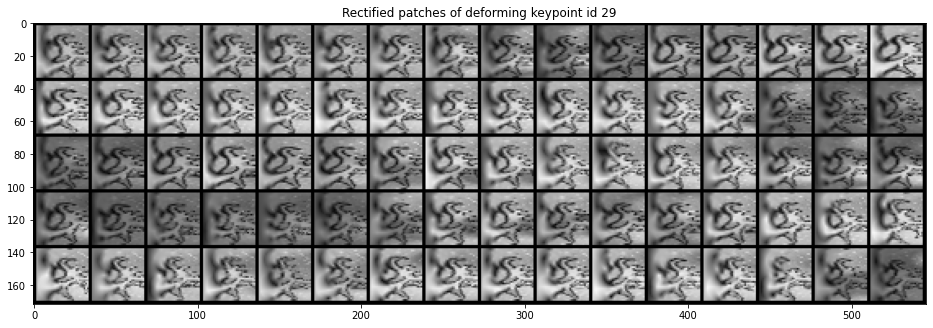

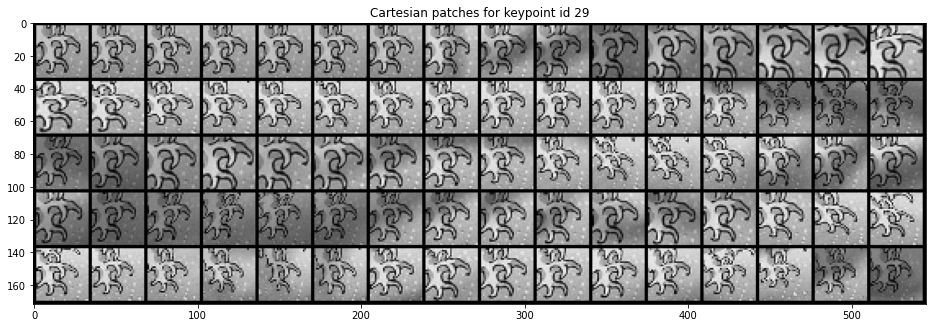

In [32]:
from torchvision.utils import make_grid

def create_gif(image_list, path):
  img, *imgs= [Image.fromarray(p.astype(np.uint8)) for p in image_list]
  img.save(fp = path, format='GIF', append_images=imgs,
          save_all=True, duration=100, loop=0)
  
t_patches = torch.tensor(patches).unsqueeze(1)
plt.figure(figsize=(16,16))
plt.title('Rectified patches of deforming keypoint id 29')
plt.imshow(make_grid(t_patches, nrow=16).permute(1,2,0).numpy().astype(np.uint8)), plt.show()

c_patches = torch.tensor(cart_patches).unsqueeze(1)
plt.figure(figsize=(16,16))
plt.title('Cartesian patches for keypoint id 29')
plt.imshow(make_grid(c_patches, nrow=16).permute(1,2,0).numpy().astype(np.uint8)), plt.show()


create_gif(patches, path = './deal_patches.gif')
create_gif(cart_patches, path = './cart_patches.gif')
create_gif(full_imgs, path = './img_sequence.gif')

### Lets visualize an animation of the deforming patches

DEAL patches


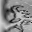

Cartesian patches


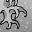

Image sequence and tracked Keypoint 29


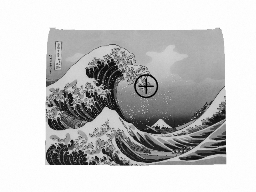

In [33]:
from IPython.display import Image, display, HTML, Markdown
print("DEAL patches")
display( Image(open('./deal_patches.gif','rb').read(), width=100) ); display(HTML('<br>'))
print("Cartesian patches")
display( Image(open('./cart_patches.gif','rb').read(), width=100) ); display(HTML('<br>'))
print('Image sequence and tracked Keypoint 29')
display( Image(open('./img_sequence.gif','rb').read(), width=400) )